<a href="https://colab.research.google.com/github/Khadiza13/DravidianLangTech-NAACL-Misogyny-/blob/main/Misogyny_run3_with_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
TRAIN_DATA_PATH = '/kaggle/input/train-dataset/train/train.csv'
EVAL_DATA_PATH = '/kaggle/input/eval-dataset/dev/dev.csv'
TEST_DATA_PATH = '/kaggle/input/test-dataset/test/test.csv'
TEST_LABELS_PATH = '/kaggle/input/test-with-labels/test_with_labels/test_with_labels.csv'
# Load the training data
train_data = pd.read_csv(TRAIN_DATA_PATH)
eval_data = pd.read_csv(EVAL_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)
test_labels=pd.read_csv(TEST_LABELS_PATH)

In [ ]:
train_label_counts = train_data['labels'].value_counts()
eval_label_counts = eval_data['labels'].value_counts()
test_label_counts=test_labels['labels'].value_counts()

# Display the counts
print("Training Data Label Distribution:")
print(train_label_counts)

print("\nValidation Data Label Distribution:")
print(eval_label_counts)

print("\nTest Data Label Distribution:")
print(test_label_counts)

Training Data Label Distribution:
labels
0    381
1    259
Name: count, dtype: int64

Validation Data Label Distribution:
labels
0    97
1    63
Name: count, dtype: int64

Test Data Label Distribution:
labels
0    122
1     78
Name: count, dtype: int64


In [ ]:
train_data.shape

(640, 3)

In [ ]:
eval_data.shape


(160, 3)

In [ ]:
test_data.shape

(200, 2)

In [ ]:
train_data.head()

,image_id,labels,transcriptions
0,888,0,\nഈ ചാടി ഓടി നടക്കണ മനുഷ്യനാണോടാ നിങ്ങളിത്രേം ...
1,554,1,മലയാള സിനിമയുടെ ഭാവി വടറാണി ഇവൾ തന്നെ നല്ല കുഴ...
2,556,1,ഒന്ന് പെറ്റത് ആണെങ്കിലും .. മുലയും വയറും ചാടിയ...
3,484,1,ഓൺലൈൻ പരിചയപ്പെട്ടവനെ കളി തരാമെന്ന് പറഞ്ഞു അപ്...
4,370,0,കാമുകിയും അൺലിമിറ്റഡ് നെറ്റ് ഓഫറുംഉള്ള പയ്യന്റ...


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, SwinModel, AutoImageProcessor, AdamW, get_scheduler
from PIL import Image
from tqdm import tqdm

# Initialize tokenizer and model for Malayalam BERT
text_tokenizer = AutoTokenizer.from_pretrained(
    "l3cube-pune/malayalam-bert",
    model_max_length=128,
    use_fast=True
)

# Malayalam BERT model
text_model = AutoModel.from_pretrained("l3cube-pune/malayalam-bert")

# Resize token embeddings to ensure alignment with tokenizer
text_model.resize_token_embeddings(len(text_tokenizer))

# Swin Transformer model and image processor
vision_processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window7-224")
vision_model = SwinModel.from_pretrained("microsoft/swin-base-patch4-window7-224")

# Custom Dataset class
class MemeDataset(Dataset):
    def __init__(self, data, tokenizer, image_path, max_len=128, is_test=False):
        self.texts = data['transcriptions'].fillna("").values
        self.image_ids = data['image_id'].values
        self.tokenizer = tokenizer
        self.image_path = image_path
        self.max_len = max_len
        self.is_test = is_test
        if not is_test:
            self.labels = data['labels'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        image_id = self.image_ids[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # Load and preprocess image
        image = Image.open(f"{self.image_path}/{image_id}.jpg").convert("RGB")
        image = vision_processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'image': image,
        }

        if not self.is_test:
            item['label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

# Define multimodal model
class MultimodalModel(torch.nn.Module):
    def __init__(self):
        super(MultimodalModel, self).__init__()

        # Text encoder using Malayalam BERT
        self.text_encoder = text_model

        # Image encoder using Swin Transformer
        self.image_encoder = vision_model

        # Combined classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(768 + 1024, 512),  # Malayalam BERT hidden size + Swin hidden size
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, 2)
        )

    def forward(self, input_ids, attention_mask, image):
        # Encode text
        text_outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        text_cls = text_outputs.last_hidden_state[:, 0, :]  # CLS token

        # Encode image
        image_outputs = self.image_encoder(pixel_values=image)
        image_cls = image_outputs.last_hidden_state[:, 0, :]  # CLS token

        # Concatenate features
        combined_features = torch.cat((text_cls, image_cls), dim=1)

        # Classify
        outputs = self.classifier(combined_features)
        return outputs


# Define image directories
train_image_dir = "/kaggle/input/train-dataset/train"
eval_image_dir = "/kaggle/input/eval-dataset/dev"
test_image_dir = "/kaggle/input/test-with-labels/test_with_labels"

# Prepare datasets and data loaders
train_dataset = MemeDataset(train_data, text_tokenizer, train_image_dir)
eval_dataset = MemeDataset(eval_data, text_tokenizer, eval_image_dir)
test_dataset = MemeDataset(test_labels, text_tokenizer, test_image_dir, is_test=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize model, optimizer, and scheduler
model = MultimodalModel()
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 5
num_training_steps = epochs * len(train_loader)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Training and evaluation functions
def train(model, data_loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        images = batch['image']
        labels = batch['label']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(outputs, labels)

        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(data_loader), correct / total

def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluation"):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            images = batch['image']
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(data_loader), correct / total, all_labels, all_preds

def predict_test(model, test_loader):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            images = batch['image']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())

    return all_preds

# Training loop
print("Starting training...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train(model, train_loader)
    eval_loss, eval_acc, _, _ = evaluate(model, eval_loader)

    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {eval_loss:.4f}, Validation Accuracy: {eval_acc:.4f}")

# Final evaluation
print("\nFinal Evaluation:")
_, _, all_labels, all_preds = evaluate(model, test_loader)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Non-Misogyny', 'Misogyny']))

Some weights of BertModel were not initialized from the model checkpoint at l3cube-pune/malayalam-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training...

Epoch 1/5


Evaluation: 100%|██████████| 10/10 [00:51<00:00,  5.18s/it]


Training Loss: 0.5645, Training Accuracy: 0.7156
Validation Loss: 0.5006, Validation Accuracy: 0.7438

Epoch 2/5


Evaluation: 100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


Training Loss: 0.2429, Training Accuracy: 0.9000
Validation Loss: 0.3708, Validation Accuracy: 0.8500

Epoch 3/5


Evaluation: 100%|██████████| 10/10 [00:50<00:00,  5.09s/it]


Training Loss: 0.1244, Training Accuracy: 0.9625
Validation Loss: 0.4839, Validation Accuracy: 0.8375

Epoch 4/5


Evaluation: 100%|██████████| 10/10 [00:50<00:00,  5.07s/it]


Training Loss: 0.0682, Training Accuracy: 0.9781
Validation Loss: 0.4464, Validation Accuracy: 0.8625

Epoch 5/5


Evaluation: 100%|██████████| 10/10 [00:51<00:00,  5.12s/it]


Training Loss: 0.0408, Training Accuracy: 0.9953
Validation Loss: 0.4353, Validation Accuracy: 0.8562

Final Evaluation:


Evaluation: 100%|██████████| 13/13 [01:04<00:00,  4.95s/it]


Classification Report:
              precision    recall  f1-score   support

Non-Misogyny       0.87      0.93      0.90       122
    Misogyny       0.87      0.78      0.82        78

    accuracy                           0.87       200
   macro avg       0.87      0.85      0.86       200
weighted avg       0.87      0.87      0.87       200



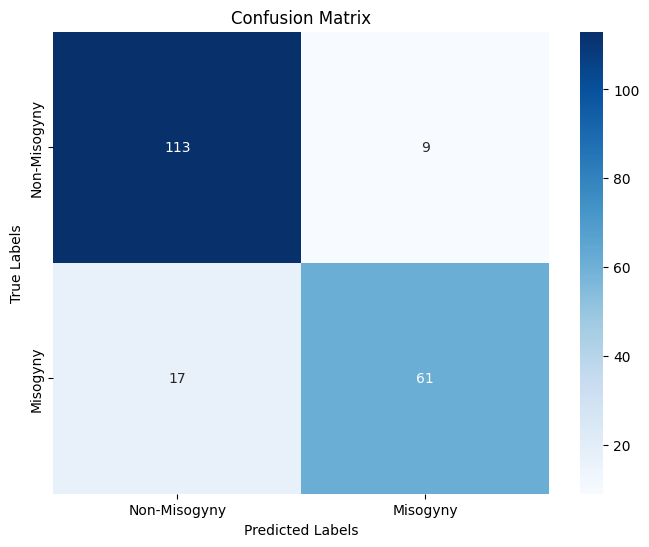

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Define class names for better readability
class_names = ['Non-Misogyny', 'Misogyny']

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoImageProcessor
from PIL import Image
from tqdm import tqdm
import os
import torch
import pandas as pd

# Initialize tokenizer and vision processor
text_tokenizer = AutoTokenizer.from_pretrained(
    "l3cube-pune/malayalam-bert",
    model_max_length=128,
    use_fast=True
)

vision_processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window7-224")

class MemeDataset(Dataset):
    def __init__(self, data, tokenizer, image_path, vision_processor, max_len=128, is_test=False):
        self.texts = data['transcriptions'].fillna("").values
        self.image_ids = data['image_id'].values
        self.tokenizer = tokenizer
        self.image_path = image_path
        self.vision_processor = vision_processor
        self.max_len = max_len
        self.is_test = is_test
        if not is_test:
            self.labels = data['labels'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        image_id = self.image_ids[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # Load and process image
        image_path = os.path.join(self.image_path, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file {image_path} not found.")

        image = Image.open(image_path).convert("RGB")
        image_processed = self.vision_processor(
            images=image,
            return_tensors="pt"
        )["pixel_values"].squeeze(0)

        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'image': image_processed,
            'image_id': image_id,  # Add image_id to the item
            'transcriptions': text  # Add transcriptions to the item for later use
        }

        if not self.is_test:
            item['label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

def predict_test_with_actuals(model, test_loader):
    model.eval()
    all_preds = []
    all_actuals = []
    all_image_ids = []
    all_transcriptions = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # Get batch size for current batch
            batch_size = batch['input_ids'].size(0)

            # Forward pass
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                image=batch['image']
            )

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())

            # If not in test mode, get the true labels as well
            if 'label' in batch:
                actuals = batch['label'].cpu().numpy()
                all_actuals.extend(actuals)

            # Convert image_ids to list if they're tensors
            if isinstance(batch['image_id'], torch.Tensor):
                batch_image_ids = batch['image_id'].cpu().numpy().tolist()
            else:
                batch_image_ids = batch['image_id']

            all_image_ids.extend(batch_image_ids)

            # Make sure transcriptions is a list
            if isinstance(batch['transcriptions'], str):
                batch_transcriptions = [batch['transcriptions']]
            else:
                batch_transcriptions = batch['transcriptions']
            all_transcriptions.extend(batch_transcriptions[:batch_size])

    # Verify all lists have the same length
    lengths = [
        len(all_preds),
        len(all_actuals) if all_actuals else len(all_preds),
        len(all_image_ids),
        len(all_transcriptions)
    ]

    if len(set(lengths)) > 1:
        print(f"Warning: Unequal lengths detected: {lengths}")
        # Trim to shortest length
        min_length = min(lengths)
        all_preds = all_preds[:min_length]
        if all_actuals:
            all_actuals = all_actuals[:min_length]
        all_image_ids = all_image_ids[:min_length]
        all_transcriptions = all_transcriptions[:min_length]

    return all_image_ids, all_transcriptions, all_actuals, all_preds


# Generate predictions and actuals
print("Generating predictions for test data...")
image_ids, transcriptions, true_labels, test_predictions = predict_test_with_actuals(model, test_loader)


# Create DataFrame safely
data_dict = {
    'image_id': image_ids,
    'transcription': transcriptions,
    'predicted_label': test_predictions
}

# Only add actual_labels if they exist
if true_labels:
    data_dict['actual_label'] = true_labels

# Create DataFrame
comparison_df = pd.DataFrame(data_dict)

# Display a few examples of actual vs predicted values
print("\nSome example predictions vs actuals:")
print(comparison_df.head(10))  # Show first 10 examples




Generating predictions for test data...


Testing: 100%|██████████| 13/13 [01:03<00:00,  4.91s/it]


Some example predictions vs actuals:
   image_id                                      transcription  \
0       954    ഇതിന് മാത്രം പിള്ളാരെ ഇവർക്കെങ്ങനെ cilşma??....   
1       239  ഇത് ഞാൻ ചെറുതായിരുന്നപ്പോൾ ഇത് 5ആം ക്ലാസ്സ് വര...   
2        61  എന്തൊക്കെ ആകിയിട്ടും ഒരു മെന വരുന്നില്ലലോ നിഖി...   
3       984  ഇഞ്ചുറിക്കു ശേഷം ഇന്റർനാഷണൽ ഫുട്ബോൾലേക്കു തിരി...   
4       774  * ഡോക്ടർ\nകണ്ണൻ സഹാവ്\nയ്യോ.. ഒരു equipment ഉള...   
5       427  നിന്റെ കാമുകി പുറത്ത് പോയതുകൊണ്ട് നീ വിഷമിക്കേ...   
6       960  MUN-SHU കളിയിൽ *Haters *Harry Maquire 1 Harry ...   
7       387  www\nAnju jr\nTODAY\nHi Chetta\n01:02 PM\nAthe...   
8       520  ഒരു ഫ്രിഡ്ജ് ഉണ്ടായിരുന്നെങ്കിൽ ഇടയ്ക്ക് ഇടയ്ക...   
9       563  തന്റെ നാല്പതാമത്തെ വയസ്സിലും ബിക്കിനി ഇട്ട് കമ...   

   predicted_label  
0                0  
1                0  
2                1  
3                0  
4                0  
5                1  
6                0  
7                0  
8                0  
9                1  
